In [1]:
# handling
import numpy as np, pandas as pd, os

# pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# ensembles for prevent overfitting
from sklearn.model_selection import KFold

# metrics
from sklearn.metrics import mean_squared_error

# modeling
import lightgbm as lgb


# time calculate
from tqdm import tqdm, tqdm_notebook
from time import sleep

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# remove message
import warnings
warnings.filterwarnings(action='ignore')

## Data Load

In [2]:
# setting path
path = '../input/drive-download-20190531t073846z-001/'

# load data
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
park = pd.read_csv(path+'park.csv')
care_center = pd.read_csv(path+'day_care_center.csv')

## Data Check

In [3]:
train.shape, test.shape, park.shape, care_center.shape

((1216553, 13), (5463, 12), (1359, 13), (7551, 11))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 13 columns):
transaction_id            1216553 non-null int64
apartment_id              1216553 non-null int64
city                      1216553 non-null object
dong                      1216553 non-null object
jibun                     1216553 non-null object
apt                       1216553 non-null object
addr_kr                   1216553 non-null object
exclusive_use_area        1216553 non-null float64
year_of_completion        1216553 non-null int64
transaction_year_month    1216553 non-null int64
transaction_date          1216553 non-null object
floor                     1216553 non-null int64
transaction_real_price    1216553 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 120.7+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5463 entries, 0 to 5462
Data columns (total 12 columns):
transaction_id            5463 non-null int64
apartment_id              5463 non-null int64
city                      5463 non-null object
dong                      5463 non-null object
jibun                     5463 non-null object
apt                       5463 non-null object
addr_kr                   5463 non-null object
exclusive_use_area        5463 non-null float64
year_of_completion        5463 non-null int64
transaction_year_month    5463 non-null int64
transaction_date          5463 non-null object
floor                     5463 non-null int64
dtypes: float64(1), int64(5), object(6)
memory usage: 512.2+ KB


In [6]:
park.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 13 columns):
city                           1359 non-null object
gu                             1356 non-null object
dong                           1359 non-null object
park_name                      1359 non-null object
park_type                      1359 non-null object
park_area                      1359 non-null float64
park_exercise_facility         277 non-null object
park_entertainment_facility    435 non-null object
park_benefit_facility          266 non-null object
park_cultural_facitiy          72 non-null object
park_facility_other            175 non-null object
park_open_year                 937 non-null float64
reference_date                 1359 non-null object
dtypes: float64(2), object(11)
memory usage: 138.1+ KB


In [7]:
care_center.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7551 entries, 0 to 7550
Data columns (total 11 columns):
city                    7551 non-null object
gu                      7551 non-null object
day_care_name           7551 non-null object
day_care_type           7551 non-null object
day_care_baby_num       7551 non-null int64
teacher_num             7326 non-null float64
nursing_room_num        4352 non-null float64
playground_num          3626 non-null float64
CCTV_num                5280 non-null float64
is_commuting_vehicle    7055 non-null object
reference_date          7551 non-null object
dtypes: float64(4), int64(1), object(6)
memory usage: 649.0+ KB


In [8]:
train.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500
3,3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.39,2003,200801,11~20,15,118000
4,4,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.43,2004,200801,21~31,3,120000


In [9]:
test.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,1145756,10453,서울특별시,목동,938,청학,목동 938 청학,35.5500,2002,201711,11~20,2
1,1198704,989,부산광역시,초량동,1143-8,고관맨션,초량동 1143-8 고관맨션,68.7200,1977,201708,21~31,2
2,1222384,8597,부산광역시,괴정동,447-13,우림그린,괴정동 447-13 우림그린,72.5400,1989,201710,11~20,2
3,1179897,11086,서울특별시,대치동,1007-2,풍림아이원4차(1007-2),대치동 1007-2 풍림아이원4차(1007-2),111.5400,2004,201707,1~10,10
4,1223091,2121,부산광역시,다대동,1670,다대롯데캐슬블루,다대동 1670 다대롯데캐슬블루,119.6398,2014,201712,11~20,21


In [10]:
park.head()

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
0,부산광역시,남구,대연동,대연공원,근린공원,55227.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
1,부산광역시,남구,대연동,당곡공원,역사공원,75465.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
2,부산광역시,남구,대연동,대일어린이공원,어린이공원,422.1,NaN,NaN,NaN,NaN,NaN,1965.0,2018-08-14
3,부산광역시,남구,대연동,못골어린이공원,어린이공원,499.8,NaN,NaN,NaN,NaN,NaN,1968.0,2018-08-14
4,부산광역시,남구,용호동,솔밭어린이공원,어린이공원,1500.2,NaN,NaN,NaN,NaN,NaN,1970.0,2018-08-14


In [11]:
care_center.head()

,city,gu,day_care_name,day_care_type,day_care_baby_num,teacher_num,nursing_room_num,playground_num,CCTV_num,is_commuting_vehicle,reference_date
0,서울특별시,서대문구,가람어린이집,국공립,70,11.0,5.0,1.0,7.0,N,2018-07-31
1,서울특별시,서대문구,가좌제일어린이집,국공립,88,22.0,5.0,2.0,10.0,N,2018-07-31
2,서울특별시,서대문구,경찰청어린이집,직장,90,23.0,6.0,1.0,32.0,N,2018-07-31
3,서울특별시,서대문구,고운햇살어린이집,가정,18,5.0,3.0,0.0,4.0,N,2018-07-31
4,서울특별시,서대문구,고은어린이집,국공립,93,20.0,7.0,2.0,10.0,N,2018-07-31


## Pre-processing

In [12]:
def park_transform(data):
    # data cleaning and outlier replace
    features = ['park_exercise_facility', 'park_entertainment_facility', 'park_benefit_facility', 'park_cultural_facitiy', 'park_facility_other']
    for feature in features:
        data.loc[data[feature]=='없음', feature] = 'nan'
        data[feature] = data[feature].apply(lambda x: str(x).replace('"', '')).apply(lambda x: 0 if x=='nan' else 1).astype(int)
    
    # remove unused data
    data = data.iloc[:, :-2]
    
    # data aggregate
    data = data.groupby(['city', 'gu', 'dong']).agg({'park_name':['size'], 
                                                     'park_area':['sum'],
                                                     'park_exercise_facility':['sum'], 
                                                     'park_entertainment_facility':['sum'],
                                                     'park_benefit_facility':['sum'],
                                                     'park_cultural_facitiy':['sum'],
                                                     'park_facility_other':['sum']}).reset_index()
    
    # remove multi columns
    data.columns = data.columns.droplevel(1)

    # data reaggregate for merge / multe columns remove
    data2 = data.groupby(['city', 'dong']).agg({'gu':['first']}).reset_index()
    data2.columns = data2.columns.droplevel(1)
    data = pd.merge(data2, data.groupby(['city', 'dong']).mean().reset_index(), how='left', on=['city', 'dong'])
    
    return data

In [13]:
park = park_transform(data=park)

# apart data and park data merge 
train = pd.merge(train, park, how='left', on=['city', 'dong'])
test = pd.merge(test, park, how='left', on=['city', 'dong'])

In [14]:
def care_center_transform(data):
    # data aggregate
    data = data.iloc[:, :-1].groupby(['city', 'gu']).agg({'day_care_name':['size'], 
                                                          'day_care_baby_num':['sum'],
                                                          'teacher_num':['sum'], 
                                                          'nursing_room_num':['sum'],
                                                          'playground_num':['sum'],
                                                          'CCTV_num':['sum']}).reset_index()
    
    # remove multi columns
    data.columns = data.columns.droplevel(1)
    
    return data

In [15]:
care_center = care_center_transform(care_center)

# apart data and care_center merge
train = train.merge(care_center, how='left', on=['city', 'gu']).fillna(0)
test = test.merge(care_center, how='left', on=['city', 'gu']).fillna(0)

## Feature engineering

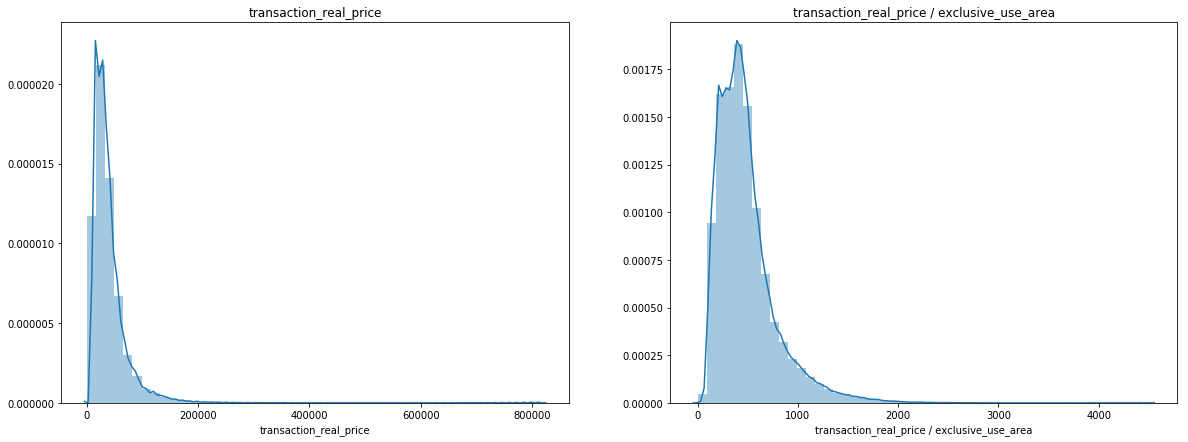

In [16]:
nrow=1;ncol=2
plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, 7))

plt.subplot(nrow, ncol, 1)
sns.distplot(train['transaction_real_price']).set_title('transaction_real_price')

plt.subplot(nrow, ncol, 2)
sns.distplot(train['transaction_real_price']/train['exclusive_use_area']).set_title('transaction_real_price / exclusive_use_area')
plt.xlabel('transaction_real_price / exclusive_use_area')
plt.show()

파생 변수를 만들기 위해 아파트의 가격을 그냥 사용하기보다 단위 면적 당 가격을 사용한다.

그 이유는 단위가 작아지기 때문에 과소, 과대추정에 보다 유리하다.

또한 target variable를 사용하여 feture engineering을 진행하는 경우 overfit의 위험이 높아지는 데 그것을 조금 감소시킬 수 있다.

In [17]:
train['var_1'] = train['transaction_real_price']/train['exclusive_use_area']

# remove y
y=train['transaction_real_price']
train.drop(columns='transaction_real_price', inplace=True)

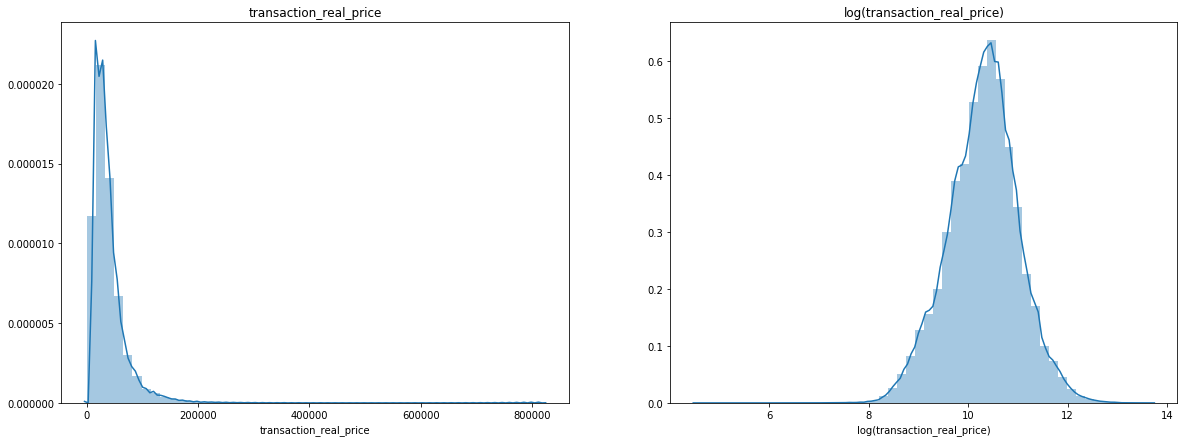

In [18]:
nrow=1;ncol=2
plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, 7))

plt.subplot(nrow, ncol, 1)
sns.distplot(y).set_title('transaction_real_price')

plt.subplot(nrow, ncol, 2)
sns.distplot(np.log(y)).set_title('log(transaction_real_price)')
plt.xlabel('log(transaction_real_price)')
plt.show()

target variable인 아파트의 실거래가는 log를 취해준 채로 예측을 하였다.

target variable의 skew되어 있는데, 이것을 log를 취해줌으로써 target variable의 정규성을 보다 만족하고 더불어 잔차의 skew도 완화시키는 장점이 있다.

또한, 단위가 감소하여 과대, 과소추정을 완화시킬 수 있다.

In [19]:
train = train.iloc[:, 1:]
test = test.iloc[:, 1:]
y = np.log(y)

### mean encoding
회귀와 분류문제에서 mean encoding은 효과적으로 점수를 상승시킬 수 있는 방법이다.

그러나 overfit의 위험이 내재되어 있기 때문에 여러가지 방법으로 ovefit을 방지한다.

Using the prior probability for regularisation, K-fold regularisation for mean encodings 등의 방법이 있는데

그러나 여기서는 2가지 방법 모두 점수가 하락하였다.

추츤컨데, train data의 양과 test data의 양이 많은 차이가 있기 때문이 아닐까 생각해보았다.

결론적으로 mean encoding을 실행하였지만, overfit을 방지하기 위한 장치는 사용하지 않았다.

In [20]:
# train mean encoding
train = pd.merge(train, train[['apartment_id', 'var_1']].groupby('apartment_id').mean().reset_index().rename(columns={'var_1':'apartment_id_mean'}), how='left', on='apartment_id')
train = pd.merge(train, train[['gu', 'var_1']].groupby('gu').mean().reset_index().rename(columns={'var_1':'gu_mean'}), how='left', on='gu')
train = pd.merge(train, train[['dong', 'var_1']].groupby('dong').mean().reset_index().rename(columns={'var_1':'dong_mean'}), how='left', on='dong')
train = pd.merge(train, train[['apt', 'var_1']].groupby('apt').mean().reset_index().rename(columns={'var_1':'apt_mean'}), how='left', on='apt')
train = pd.merge(train, train[['addr_kr', 'var_1']].groupby('addr_kr').mean().reset_index().rename(columns={'var_1':'addr_kr_mean'}), how='left', on='addr_kr')
train = pd.merge(train, train[['jibun', 'var_1']].groupby('jibun').mean().reset_index().rename(columns={'var_1':'jibun_mean'}), how='left', on='jibun')
train = pd.merge(train, train[['floor', 'var_1']].groupby('floor').mean().reset_index().rename(columns={'var_1':'floor_mean'}), how='left', on='floor')
train.drop(columns='var_1', inplace=True)

# test mean encoding
test = pd.merge(test, train[['apartment_id', 'apartment_id_mean']].drop_duplicates(), how='left', on='apartment_id')
test = pd.merge(test, train[['gu', 'gu_mean']].drop_duplicates(), how='left', on='gu')
test = pd.merge(test, train[['dong', 'dong_mean']].drop_duplicates(), how='left', on='dong')
test = pd.merge(test, train[['apt', 'apt_mean']].drop_duplicates(), how='left', on='apt')
test = pd.merge(test, train[['addr_kr', 'addr_kr_mean']].drop_duplicates(), how='left', on='addr_kr')
test = pd.merge(test, train[['jibun', 'jibun_mean']].drop_duplicates(), how='left', on='jibun')
test = pd.merge(test, train[['floor', 'floor_mean']].drop_duplicates(), how='left', on='floor')

# train, test data merge
data = pd.concat([train, test], sort=False)

mean encoding의 기준은 one hot encoding을 할 수 없는 만큼의 unique value를 가지고 있는 feature들을 선정하였다.

또한 Label encoding과 one hot encoding을 실행하기 위해 train, test data를 merge하였다.

In [21]:
# fill na value with median
for feature in data.columns[data.isnull().sum()!=0]:
    data[feature] = data[feature].fillna(data[feature].median())

안타깝게도 test data에 있는 값들이 train data에 없는 경우가 있었기에 median으로 대체하였다.

In [22]:
# 각 gu, dong, jibun, addr_kr에서 apart의 count
data = pd.merge(data, data[['gu', 'apartment_id']].groupby('gu').count().reset_index().rename(columns={'apartment_id':'apt_count_gu'}), how='left', on='gu')
data = pd.merge(data, data[['dong', 'apartment_id']].groupby('dong').count().reset_index().rename(columns={'apartment_id':'apt_count_dong'}), how='left', on='dong')
data = pd.merge(data, data[['jibun', 'apartment_id']].groupby('jibun').count().reset_index().rename(columns={'apartment_id':'apt_count_jibun'}), how='left', on='jibun')
data = pd.merge(data, data[['addr_kr', 'apartment_id']].groupby('addr_kr').count().reset_index().rename(columns={'apartment_id':'apt_count_addr_kr'}), how='left', on='addr_kr')
data = pd.merge(data, data[['apartment_id', 'floor']].groupby('apartment_id').median().reset_index().rename(columns={'floor':'floor_median'}), how='left', on='apartment_id')

# transaction_year_month를 year와 month로 분리
data['transaction_year'] = data['transaction_year_month'].apply(lambda x: int(str(x)[:4]))
data['transaction_month'] = data['transaction_year_month'].apply(lambda x: int(str(x)[4:]))
data['diff_year'] = data['transaction_year'] - data['year_of_completion']

# add rebuilding feature(30년 기준)
data['rebuilding'] = data['diff_year'].apply(lambda x: 1 if x>=30 else 0)
data['floor2'] = data['floor'].apply(lambda x: 1 if x<=30 else 2)

# label encoding
label_features = ['apartment_id', 'gu', 'dong', 'apt', 'jibun', 'addr_kr', 'transaction_year_month']
for feature in label_features:
    data[feature] = LabelEncoder().fit_transform(data[feature].astype(str))

# one hot encoding
dummy_features = ['city', 'transaction_date', 'year_of_completion', 'transaction_year', 'transaction_month', 'rebuilding', 'floor2']
data = pd.concat([data.drop(columns=dummy_features), pd.get_dummies(data[dummy_features].astype(str))], axis=1)

# missing data count
data['count_0'] = (data==0).sum(axis=1)
data['count_1'] = (data==1).sum(axis=1)

In [23]:
# separate train, test data
train = data.iloc[:train.shape[0], :]
test = data.iloc[train.shape[0]:, :]

## modeling

In [24]:
param = {'num_leaves': 200,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': 16,
         'learning_rate': 0.1,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1
         }

파라미터의 경우 휴리스틱하게 진행하였고, learning time을 줄이기 위해 learning_rate를 0.1로 고정하였다.

In [25]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))

splits=5
kf = KFold(n_splits=splits, random_state=42, shuffle=True)

with tqdm_notebook(total=splits, desc='training...') as pbar:
    for tr_idx, val_idx in kf.split(train, y):
        
        lgb_train = lgb.Dataset(train.loc[tr_idx], label=y[tr_idx])
        lgb_valid = lgb.Dataset(train.loc[val_idx], label=y[val_idx])

        reg = lgb.train(param, lgb_train, 100000, valid_sets = [lgb_train, lgb_valid], early_stopping_rounds = 500, verbose_eval=5000)

        oof[val_idx] = reg.predict(train.loc[val_idx], num_iteration=reg.best_iteration)
        predictions += reg.predict(test, num_iteration=reg.best_iteration)/kf.n_splits
        
        print(np.sqrt(mean_squared_error(np.exp(y[val_idx]), np.exp(oof[val_idx]))))
        
        sleep(0.1)
        pbar.update(1)

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2585]	training's rmse: 0.0515386	valid_1's rmse: 0.0713213
3390.2941230120996
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2668]	training's rmse: 0.0510871	valid_1's rmse: 0.0715776
3527.71760188635
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[3008]	training's rmse: 0.049392	valid_1's rmse: 0.0731492
3809.297987425938
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2719]	training's rmse: 0.050776	valid_1's rmse: 0.0721657
3482.293698836335
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[2650]	training's rmse: 0.0512253	valid_1's rmse: 0.0712591
3383.812195910567



tqdm을 사용하여 진행시간을 확인하고자 하였고, oof를 사용하여 일반화하였다.

In [26]:
np.sqrt(mean_squared_error(np.exp(y), np.exp(oof)))

3522.10721954149

In [27]:
sub = pd.read_csv(path+'submission.csv')
sub['transaction_real_price']=np.exp(predictions)
sub.to_csv('submission.csv', index=False)